Data wrangling is a core part of data engineering. sourcing, merging and 
storing data to a format that is digestable for analysis and machine learning.
This Notebook consists of code to access data about the NY social diary. I used an API to 
access the dataset with the [documentation](https://party-captions.tditrain.com) describing how this API works in detail.

Objective of the task: 
1. Get all parties from Dec 2014
1. Parse the names for the rest of the parties
2. Generate relationships and save dataset for graph analysis

In [1]:
import requests
import pandas as pd 
import pickle

"""
Testing the functionality of the API
"""
url = 'https://party-captions.tditrain.com/parties'
params = {
    'limit': 20,
    'offset': 0
}

response = requests.get(url, params)
response

<Response [200]>

1. Get all parties from Dec 2014

In [ ]:
"""
Here we go ahead and extract all the parties pages in the API. We go ahead to store the data in a pickle to for quick retrival.
"""
parties = []
for offset in range(0, 10000, params['limit']):
    params['offset'] = offset
    response = requests.get(url, params=params)
    if response.status_code == 200:
        parties+= response.json()['parties']
    else:
        print(f"Error occurred: HTTP {response.status_code} - {response.text}")

#creating a pickle
import pickle
with open('all_parties.pkl', 'wb') as pk:
    pickle.dump(parties, pk)

In [4]:
#ccnfirming the number of parties....
with open('all_parties.pkl', 'rb') as f:
    data = pickle.load(f)
len(data)

1175

In [7]:
from collections import Counter
import datetime
"""
Creating a histogram  showing the frequency of dates for all the parties.  
"""

# Convert date strings to datetime objects and extract month-year pairs
month_year_pairs = [datetime.datetime.strptime(entry['date'], '%Y-%m-%d').strftime('%b-%Y') for entry in data]

# Count the occurrences of each month-year pair
histogram = Counter(month_year_pairs)

# Create a list of tuples in the desired format ("Dec-2014", 1)
result = [(pair, count) for pair, count in histogram.items()]
len(result)
result[0]

('Mar-2015', 5)

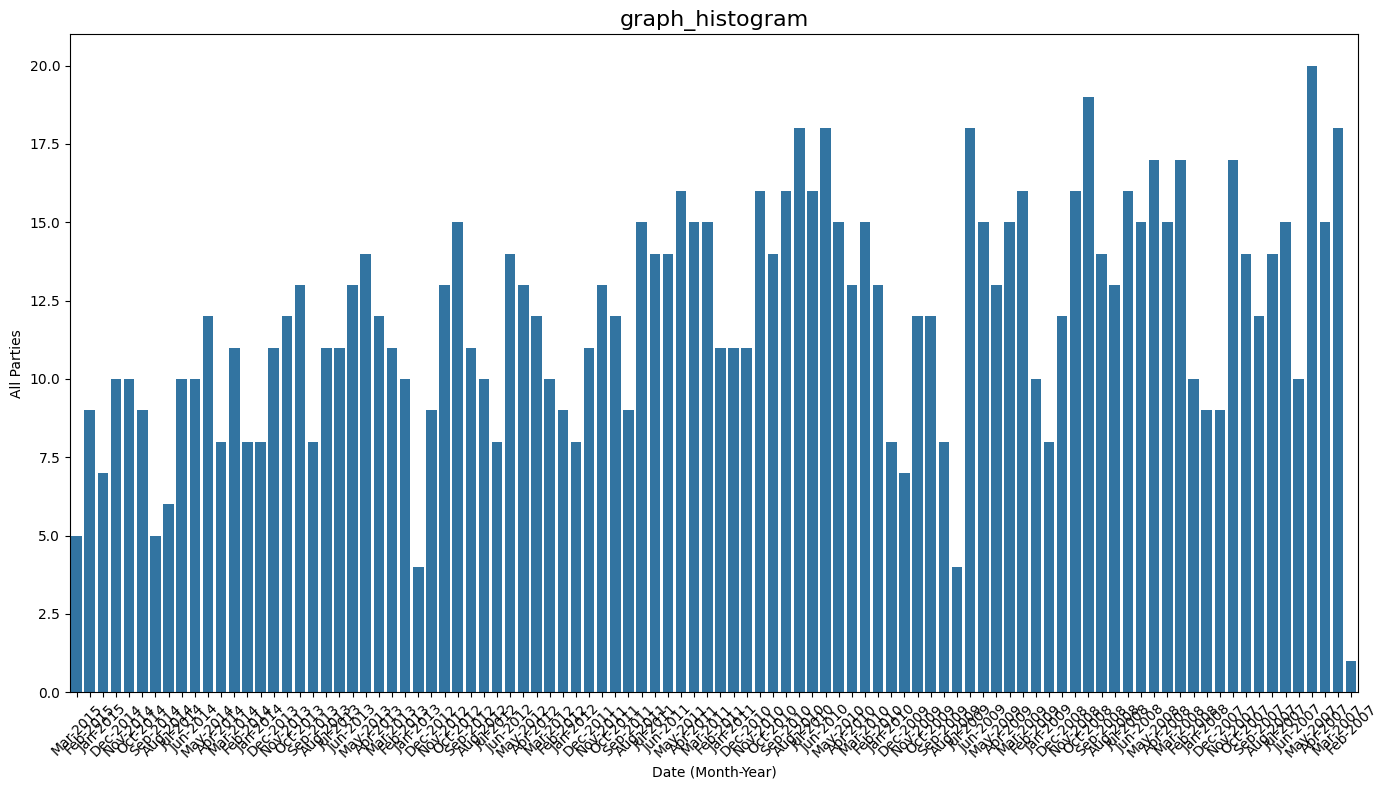

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.figure(figsize=(14, 8))  # Increased figure size for clarity
sns.barplot(x=[l[0] for l in result], y=[l[1] for l in result])

# Adjust labels
plt.xlabel("Date (Month-Year)", fontsize=10)
plt.ylabel("All Parties", fontsize=10)
plt.xticks(rotation=45, fontsize=10)  # Rotated x-axis labels for better visibility
plt.title("graph_histogram", fontsize=16)

# Ensure layout fits well
plt.tight_layout()

# Display the plot
plt.show()

2. Parse the names from each caption for one party.
Part B: Parsing party captions. Each party has a name and a data, and for every party name, there are records of pictures with captions. These captions are generally names of folks that attended the parties.  The goal is to grab these captions and later derive relationships among the people that attended these parties. 

In [11]:
#sampling a single party
#end point is caption
"""
Now that we have all the parties, the API also has the captions for each and every picture on each party page. 
The function below returns all captions for each and every party. We can achieve this 2 ways, one, create a json file or 
csv file that constitutes the party key, and all captions to it. 
For simplicity, all the data is extracted to a dataframe for RDBMS storage.  
"""
# data[0:100]
# data[0]['date']
part_dec = [ p for p in data if p['date'] < '2014-12-02']

import pickle
data = part_dec
def get_captions(party_name):
    url = 'https://party-captions.tditrain.com/captions?party={}'.format(party_name)
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['captions']
    return []

# #execute
# cap_party1 = get_captions('2015-celebrating-the-neighborhood')
# cap_party1

In [ ]:
# #the option to save the data to csv and keep incrementing optionally
# #create party count per month. 
# df = pd.DataFrame(part_dec)

# #slit month year pairs
# df['date'] = pd.to_datetime(df['date'])
# df['month_year'] = df['date'].dt.strftime('%b-%Y')
# df['day'] = df['date'].dt.strftime('%d')
# df.head(2)

# df['captions'] = df['name'].apply(
#     lambda name: [caption.replace('\n', '').strip() for caption in get_captions_cached(name) 
#                   if caption.strip()]
# )

# # Display the updated DataFrame
# print(df.head())

# #df.to_csv('all_caption.csv', index=False)
# df = pd.read_csv('all_caption.csv')
# df.head(3)

In [ ]:
#getting all names of captions
captions_all = []

for entry in data:
    party_name = entry['name']
    captions = get_captions(party_name)
    
    # Filter out empty captions and remove newline characters
    captions = [caption.replace('\n', '').strip() for caption in captions if caption.strip()]
    # Extend captions_all with non-empty captions
    captions_all.extend(captions)

    # Save the captions using ediblepickle
with open("all_captions.pickle", "wb") as file:
    pickle.dump(captions_all, file)

In [ ]:
#reload captions saved in pickle
with open("all_captions.pickle", "rb") as file:
    captions_all = pickle.load(file)
    
captions_all[0:10]

['The scene at   IDEAL School & Academy’s  10th\xa0Annual Gala.',
 'Les Lieberman, Barri Lieberman, Isabel Kallman, Trish Iervolino, and Ron Iervolino',
 'Chuck Grodin',
 'Diana Rosario, Ali Sussman, Sarah Boll, Jen Zaleski, Alysse Brennan, and Lindsay Macbeth',
 'Kelly  and Tom Murro',
 'Udo Spreitzenbarth',
 'Ron Iervolino, Trish Iervolino, Russ Middleton, and Lisa Middleton',
 'Barbara Loughlin, Dr. Gerald Loughlin, and Debbie Gelston',
 'Julianne Michelle',
 'Heather Robinson, Kiwan Nichols, Jimmy Nichols, Melanie Carbone, and Nancy Brown']

3. Parse the names for the rest of the parties
There are various methods to parse these names.
- Using regex
- Using nlp 

In [17]:
"""
Creating a short preview to sample the names in captions using spacy model.
"""

import spacy
from spacy import displacy
NER = spacy.load('en_core_web_sm')

df = pd.read_csv(r'C:\Users\pc\Desktop\STELLA_SPACE\wrangling\wrangling\wrangling\all_caption.csv')
trial = df['captions'][5]
trial

'["The scene at Michael\'s 25th anniversary celebration.", \'Danny DiVella, Steve Millington, Kyung Up Lim, Robyn Levy-Wolf, Mario Moise, and Michael McCarty\', \'Blythe Danner, Dr. Ruth Westheimer, and Laurie Tisch\', \'Nancy Spears and Sissy Biggers\', \'Sean Kelly, Cecile Panzieri, and Lauren Kelly\', \'Paul Karian and Simone Karian\', \'Kim McCarty, Susan Magrino Dunning, and Allyn Magrino Holmberg\', \'Susan Silver and Joel Wachs\', \'Rikki Klieman and Steve Millington\', \'Ellen Niven and Cornelia Guest\', \'Liz Byrne and Gerry Byrne\', \'Joel Schnell and Lynn White\', \'Joan Kron and Jonathan Marder\', \'Paige Peterson\', \'L.A. Perkel, Jonathan Perkel, and Dagny Corcoran\', \'Scott Merkin and Susan Blond\', \'Shari Rollins and Rick Friedberg\', \'Les Moonves and Matt Blank\', \'Hilary Gumbel and Bryant Gumbel\', \'John Hart and Nicolle Meyer\', \'Debbie Bancroft and Daniel Benedict\', \'Kath Hinton and Les Hinton\', \'Edward Klein and Penny Worth\', \'Joanna Coles and Peter God

In [23]:
trial_str = ''.join(trial)
text1 = NER(trial_str)
for word in text1.ents:
    #print(word.text, word.label_)
    #print(f'Successfully done')
    break 
    
displacy.render(text1,style="ent",jupyter=True)

3. Generate relationships and save dataset for graph analysis

Our goal is to create a graph database to support analysis of relationships in the names of party goers for these years. 
To achieve this, we have to identify and extract individual names, groups of names from the captions, 
and then determine relationships between the 2. 

In [26]:
#function to extract all names and groups from captions
def extract_persons(captions):
    individual_names = []
    group_names = []
    
    # Process text in chunks
    chunk_size = 100000  # Define chunk size
    for i in range(0, len(captions), chunk_size):
        chunk = captions[i:i + chunk_size]
        
        # Apply NER to the chunk
        text1 = NER(chunk)
        persons = [ent.text for ent in text1.ents if ent.label_ == 'PERSON']
        
        for name in persons:
            if "and" in name:
                group_names.append(name)
            else:
                individual_names.append(name)
                
    return individual_names, group_names

# Split captions into chunks and join them in a loop
captions_text = ' '.join(captions_all)

# Extract individual and group names from captions
individual_names, group_names = extract_persons(captions_text)

In [ ]:
#CREATE RELATIONSHIPS
""" 
1. Graph Schema
Nodes
Individual:
Label: Person
Attributes:
name: String (e.g., "Les Lieberman")
Group:
Label: Group
Attributes:
name: String (e.g., "Les Lieberman and Barri Lieberman")
members: List of strings (optional, e.g., ["Les Lieberman", "Barri Lieberman"] for traceability)

Here the rules for Node Creation
Individual Nodes: Created for all isolated names in the captions (e.g., "Chuck Grodin", "Julianne Michelle").
Group Nodes: Created for captions containing names linked with "and".
Example:
Caption: "Les Lieberman and Barri Lieberman"
Create:
Node: Group {name: "Les Lieberman and Barri Lieberman"}
Nodes: Person {name: "Les Lieberman"}, Person {name: "Barri Lieberman"}
Edges: (:Person {name: "Les Lieberman"})-[:MEMBER_OF]->(:Group) (:Person {name: "Barri Lieberman"})-[:MEMBER_OF]->(:Group)

Relationships: Two or more people/groups mentioned together in the same caption imply an ASSOCIATED_WITH relationship.
Example:
Caption: "Les Lieberman and Barri Lieberman, Isabel Kallman, Trish Iervolino"
Create relationships:
(:Group {name: "Les Lieberman and Barri Lieberman"})-[:ASSOCIATED_WITH]->(:Person {name: "Isabel Kallman"})
(:Person {name: "Isabel Kallman"})-[:ASSOCIATED_WITH]->(:Person {name: "Trish Iervolino"})

"""

# Initialize storage
all_individuals = set()
all_groups = set()

# Process captions
for caption in captions_all:
    individual_names, group_names = extract_persons(captions_text)
    all_individuals.update(individual_names)
    all_groups.update(group_names)

# Display results
print("Individuals:", len(all_individuals))
print("Groups:", len(all_groups))

In [ ]:
#since this graph is extremely huge with over 100k names, a sample o 500 is selected to map and save relationships
# Combine individuals and groups
all_entities = list(all_individuals) + list(all_groups)

# Limit to first 5,000 entities
limited_entities = all_entities[:500]

In [ ]:
import csv
#Generate relationships for the number of entities.
def create_relationships(entities):
    relationships = []
    
    # Create ASSOCIATED_WITH relationships for limited entities
    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            relationships.append((entities[i], "ASSOCIATED_WITH", entities[j]))

    return relationships

# Generate relationships for the first 500 entities
relationships = create_relationships(limited_entities)
print(f"Generated {len(relationships)} relationships for the first 500 entities.")


# Save relationships to a CSV file
with open('relationships.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(['Source', 'Relationship', 'Target'])
    # Write each relationship
    for source, relation, target in relationships:
        writer.writerow([source, relation, target])

In [ ]:
#BUILDING THE GRAPH
#Now building a multigraph
import networkx as nx

def multigraph(individual_names, group_names):
    G = nx.Graph()
    
    # Add individual names as nodes
    for individual in individual_names:
        G.add_node(individual, type='individual')
    
    # Add group names as nodes and connect to individuals
    for group in group_names:
        G.add_node(group, type='group')
        
        # Splitting group names into  individuals
        members = group.split("and")
        members = [member.strip() for member in members]
        for member in members:
            if member in individual_names:
                G.add_edge(group, member)
    return G

# Build the graph
G = multigraph(individual_names, group_names)

In [ ]:
#visualize a sample
import random
# Function to sample a subset of nodes and create a subgraph
def sample_graph(G, num_nodes=5000):
    # Convert G.nodes to a list for sampling
    node_list = list(G.nodes)
    
    # Randomly sampling of  nodes if more than set limit
    if len(node_list) > num_nodes:
        sampled_nodes = random.sample(node_list, num_nodes)
    else:
        sampled_nodes = node_list
    
    # Create a subgraph with the sampled nodes
    subgraph = G.subgraph(sampled_nodes)
    return subgraph

# Sample 5000 nodes
sampled_G = sample_graph(G, num_nodes=5000)

In [ ]:
# Visualize the graph
def visualize_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # Layout for nodes
    node_colors = ['blue' if G.nodes[node]['type'] == 'individual' else 'green' for node in G.nodes]
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=500,
        font_size=10,
        font_color='black',
        edge_color='gray'
    )
    plt.title("Social Graph")
    plt.show()

# Call visualization function
visualize_graph(sampled_G)